In [1]:
import os
from mat_utils import load_file, parse_math
from utils import select_filenames_by_key_word, select_filenames_by_key_word_neg
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy.fftpack import fft

In [2]:
original_seq_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/rxGridSSBurstIdeal.mat"
data_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/Data_raw"

In [3]:
mat_file = load_file(original_seq_path)
pss_sss_raw = mat_file['rxGridSSBurst'][:,:4]

In [10]:
all_folders = os.listdir(data_path)
all_folders = [x for x in all_folders if not x ==  '.ipynb_checkpoints']

folder_train = ['comeretial']
folder_valid_true = ['Fake_Bts_PCI_466']
folder_valid_false = ['Fake_Bts_PCI_466_wPA']

folders_test_false = ["Fake_Bts_PCI_466_wPA_traffic", "Fake_Bts_PCI_12_wPA"]
folders_test_true = ["Fake_Bts_PCI_12", "Fake_Bts_PCI_466_traffic"]

processed_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/Data_channels/"

In [11]:
def repeat_fiels(original_seq, final_seq_shape):
    repeated_seq = np.repeat(original_seq, final_seq_shape[1]//original_seq.shape[1], axis=1)
    if not repeated_seq.shape[1] == final_seq_shape[1]:
        repeated_seq = np.concatenate((repeated_seq, original_seq[:,:2]), axis=1)
    
    return repeated_seq
def to_log(values: np.array) -> np.array:
    return -20 * np.log10(values)

def estimate_channels(signal, original_sequence):
    multiply = signal.shape[1]//4
    new_seq = np.repeat(original_sequence, multiply, axis=1)

    if not signal.shape[1]%4 == 0:
        new_seq = np.concatenate((new_seq, original_sequence[:,:2]), axis=1)

    return signal/new_seq

def complex_to_arr(array):
    real = array.real
    imag = array.imag

    real = real.T
    imag = imag.T

    ret_arr = []

    for real_sl, imag_sl in zip(real, imag):
        new_rr = np.concatenate((real_sl.reshape((-1,1)), imag_sl.reshape((-1,1))), axis=1)
        ret_arr.append(new_rr)
        
    return np.array(ret_arr)
    

def process_data_in_folder(folder_name, type):
    source_path = os.path.join(data_path, folder_name)
    all_files = os.listdir(source_path)

    saving_path = os.path.join(processed_path, type, folder_name)
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)

    counter = 0
    
    for signle_file_name in all_files:
        full_path_file = os.path.join(source_path, signle_file_name)
        file_loaded = np.load(full_path_file)

        channel_estimation = estimate_channels(file_loaded, pss_sss_raw)
        channel_estimation = channel_estimation.reshape((channel_estimation.shape[0]*2, channel_estimation.shape[1]//2))

        array_channel_estimation = complex_to_arr(channel_estimation)

        for id_x, single_data in enumerate(array_channel_estimation):
            single_file_path = os.path.join(saving_path, f"{id_x}_" + signle_file_name)
            np.save(single_file_path, single_data)


        """
        channel_estimation = np.abs(channel_estimation)
        channel_estimation = to_log(channel_estimation)
        
    
        freqs_pss = range(72)
        plt.figure()
        plt.plot(freqs_pss, channel_estimation[:,:2])
        plt.xlim([1,72])
        plt.ylim([-70,10])
        plt.xlabel("no. freq")
        plt.ylabel("channel")
        plt.grid()
        
        
        counter += 1
        
        if counter >5:
        
        
            break
        """
    

def process_data_in_folders(folders_names, type="train"):

    for folder_name in folders_names:
        process_data_in_folder(folder_name, type=type)


In [14]:
#process_data_in_folders(folder_train, "train")
process_data_in_folders(folder_valid_true, "valid")
process_data_in_folders(folder_valid_false, "valid")

process_data_in_folders(folders_test_false, "test")
process_data_in_folders(folder_test_true, "test")

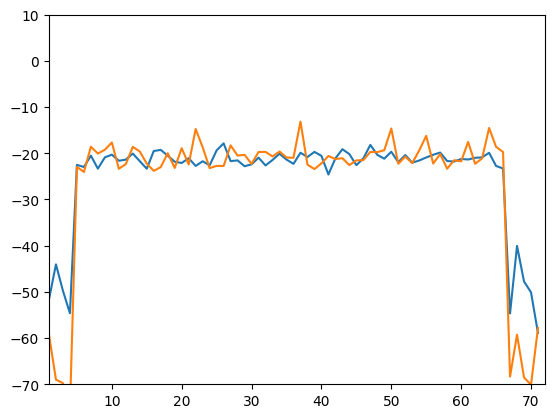

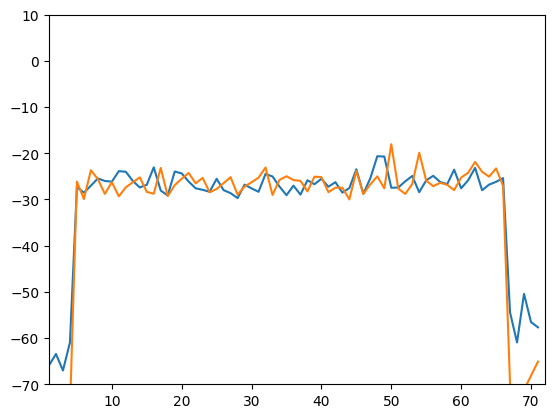

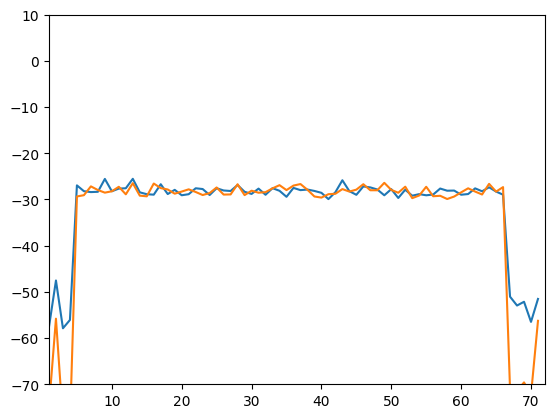

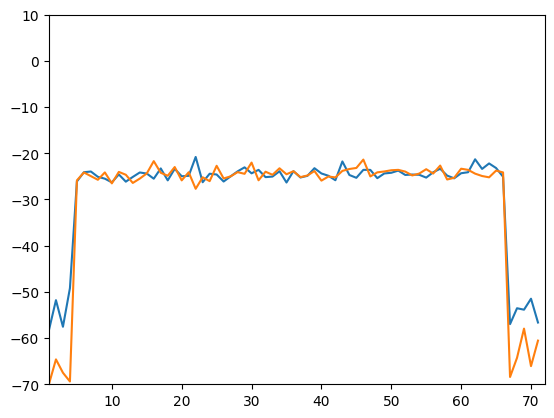

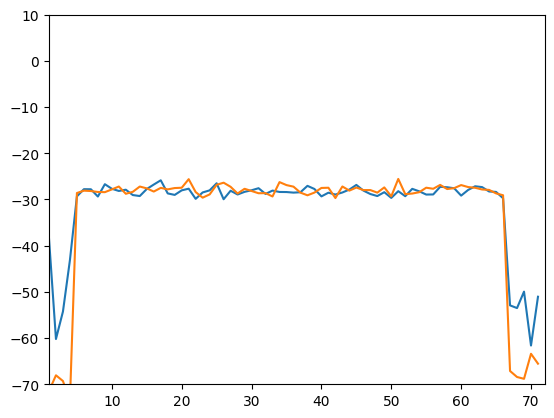

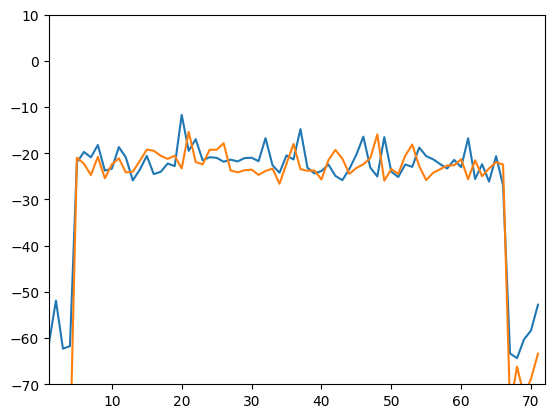

In [38]:
counter = 0

for single_file_name in all_files_received:
    single_file = np.load(os.path.join(data_path, key_world, single_file_name))[:,:4]

    channel_estimation = estimate_channels(single_file, pss_sss_raw)
    
    
    channel_estimation = np.abs(channel_estimation)
    channel_estimation = to_log(channel_estimation)
    

    freqs_pss = range(72)
    plt.figure()
    plt.plot(freqs_pss, channel_estimation[:,:2])
    plt.xlim([1,72])
    plt.ylim([-70,10])
    
    counter += 1
    
    if counter >5:
    
    
        break

In [132]:
channel_estimation.shape

(72, 52)

In [60]:
def to_log(values: np.array) -> np.array:
    return 20 * np.log10(values)

In [61]:
def mean_channel_by_seq(signal: np.array, n_channels: int = 1):
    n_signals = (signal.shape[1]//2)//n_channels

    all_signals = np.array([])
    
    for x in range(n_signals):
        single_signal_sss = signal[:, range((n_channels*2*x),(n_channels*2*(x+1)),2)]
        single_signal_pss = signal[:, range((n_channels*2*x) + 1,(n_channels*2*(x+1)),2)]

        mean_sss = np.expand_dims(np.mean(single_signal_sss, axis=1), axis=1)
        mean_pss = np.expand_dims(np.mean(single_signal_pss, axis=1), axis=1)
        cnt = np.concatenate((mean_sss, mean_pss), axis=1)

        if len(all_signals) == 0:
            all_signals = cnt
        else:
            all_signals = np.concatenate((all_signals, cnt), axis=1)

    return np.asarray(all_signals)

In [62]:
def get_cross_corelation(signal_a: np.array, signal_b: np.array):
    return np.correlate(signal_a, signal_a, mode='full')

In [63]:
def estimate_channels(signal, original_sequence):
    multiply = signal.shape[1]//4
    new_seq = np.repeat(original_sequence, multiply, axis=1)

    if not signal.shape[1]%4 == 0:
        new_seq = np.concatenate((new_seq, original_sequence[:,:2]), axis=1)

    return new_seq/signal

In [64]:
full_path_received = os.path.join(paths[key_world], all_files_received[2])
mat_file_received = np.load(full_path_received)

In [65]:
new_channel = estimate_channels(mat_file_received, pss_sss_raw)
#new_channel = mean_channel_by_seq(new_channel)

In [66]:
h_abs = new_channel
h_abs = np.abs(h_abs)
h_abs = mean_channel_by_seq(h_abs, n_channels = mean_vals)
#h_abs = to_log(h_abs)



#h_abs = to_log(h_abs)

In [67]:
h_abs.shape

(72, 48)

(72, 48)


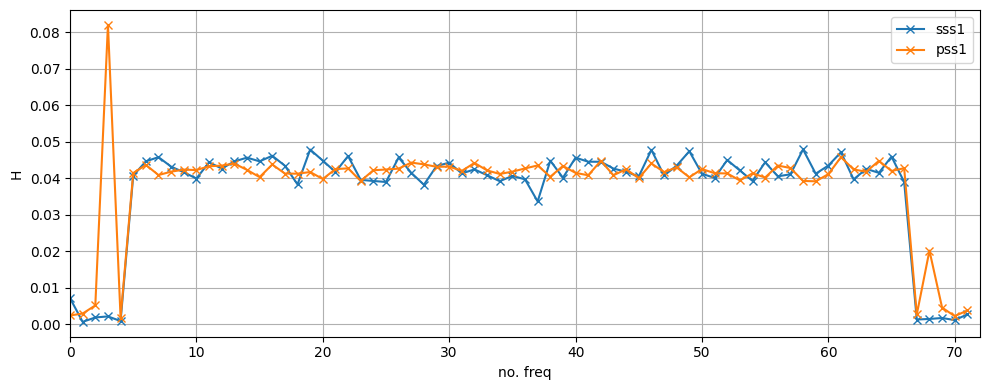

(72, 48)


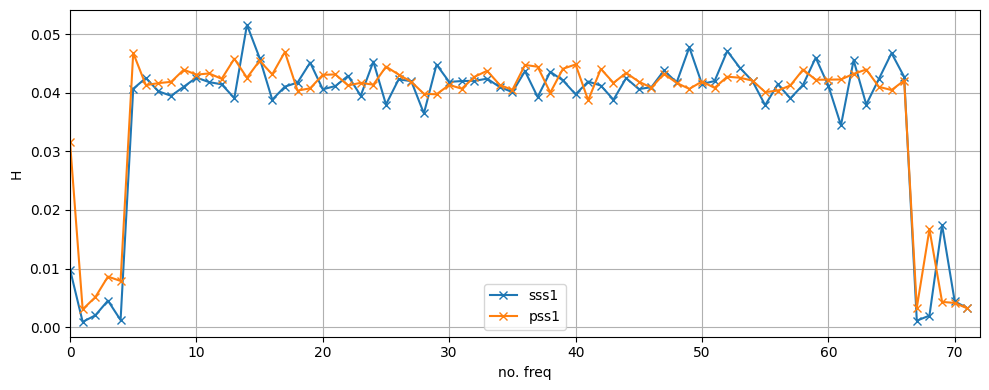

(72, 48)


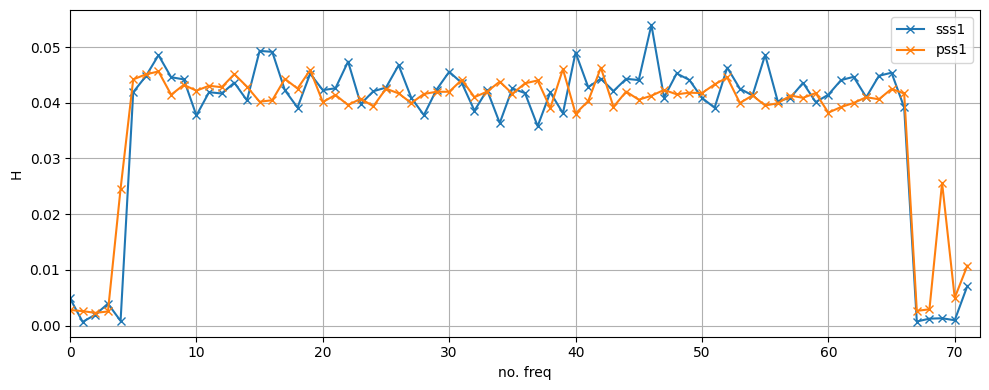

(72, 48)


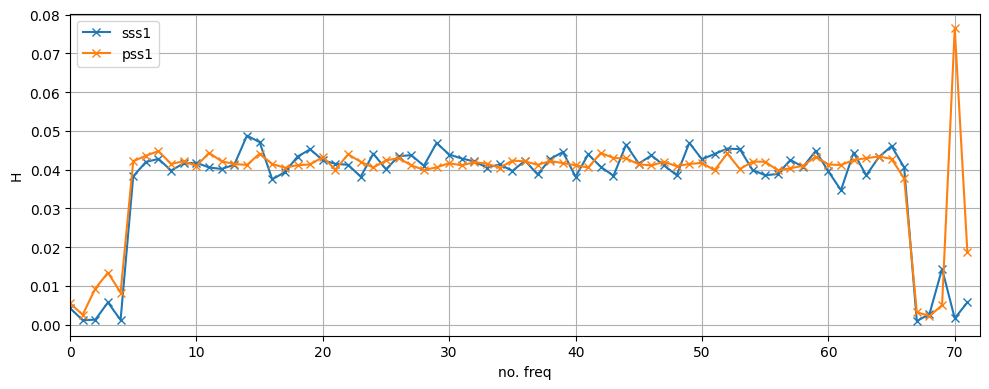

(72, 48)


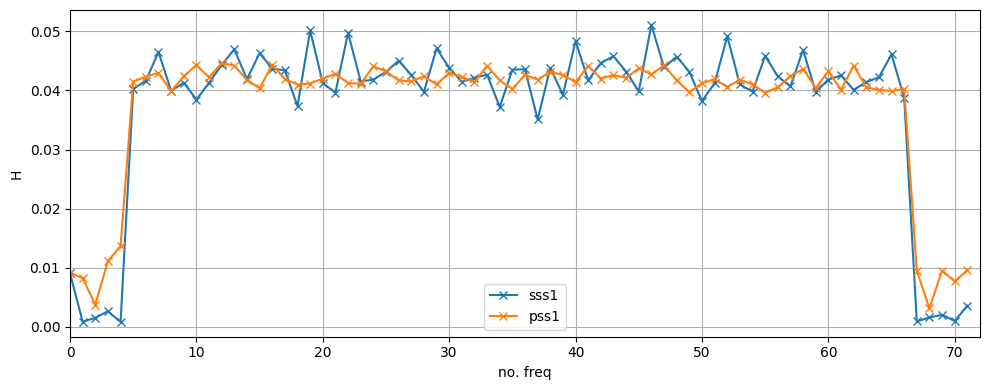

(72, 48)


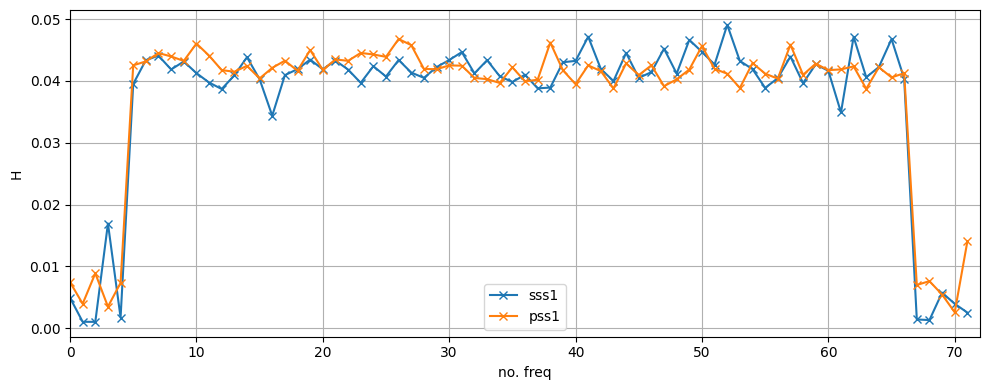

(72, 48)


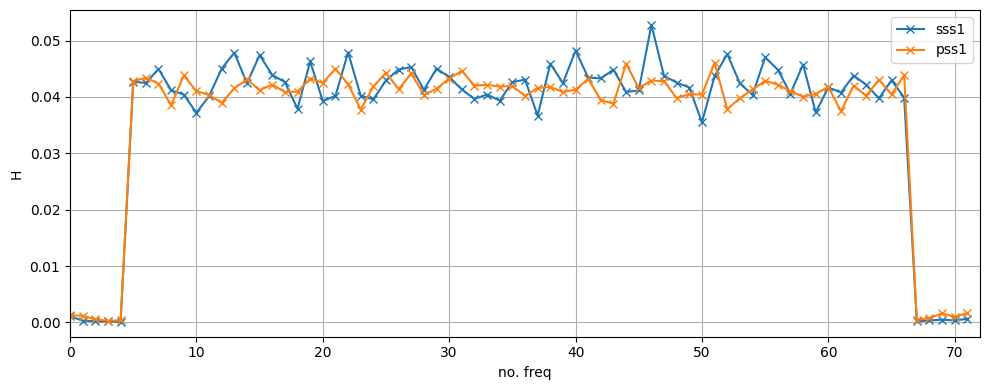

(72, 48)


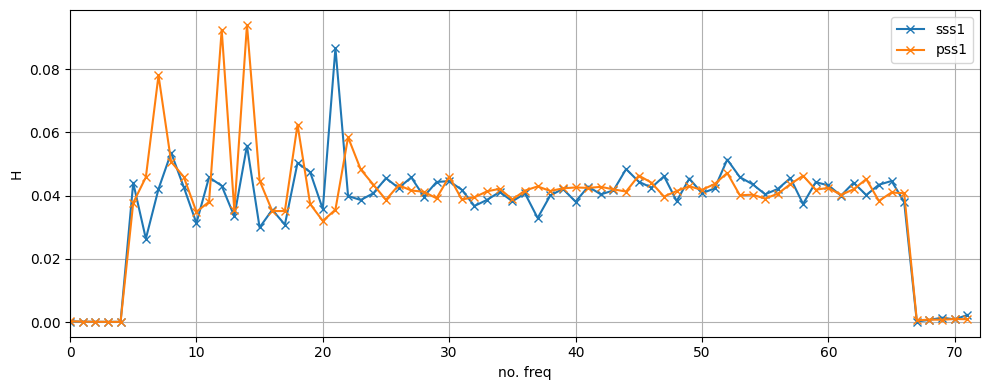

(72, 48)


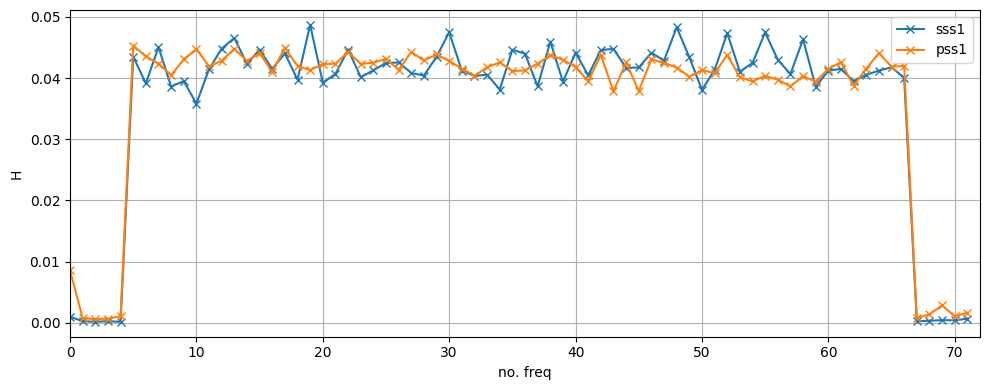

(72, 48)


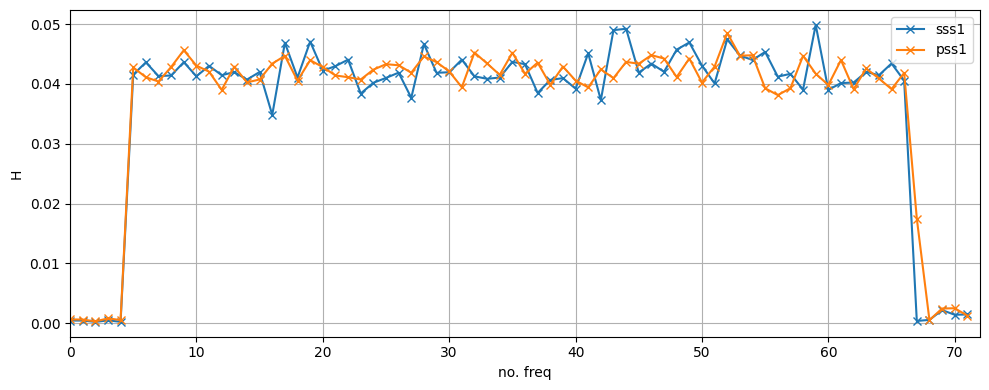

(72, 48)


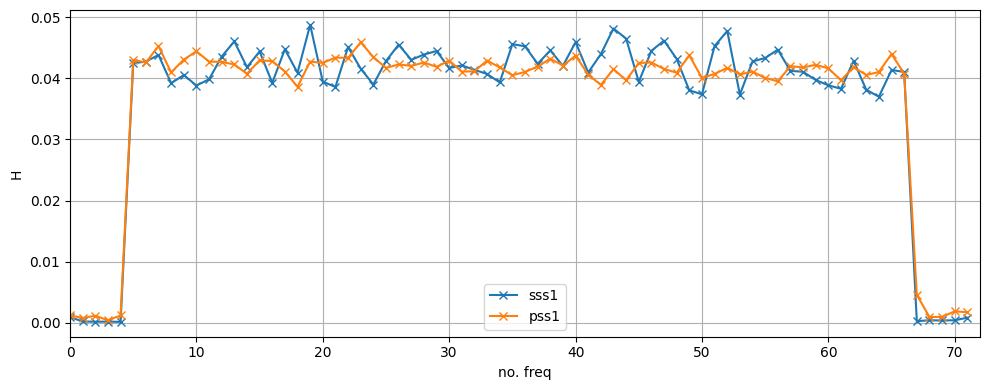

(72, 48)


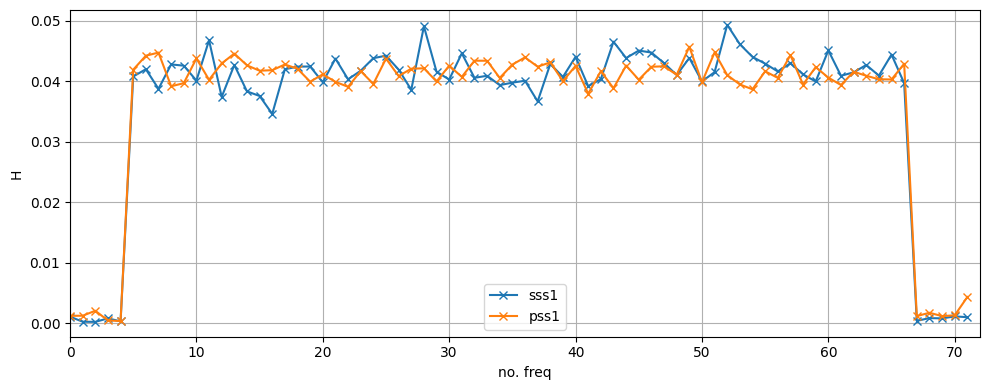

(72, 48)


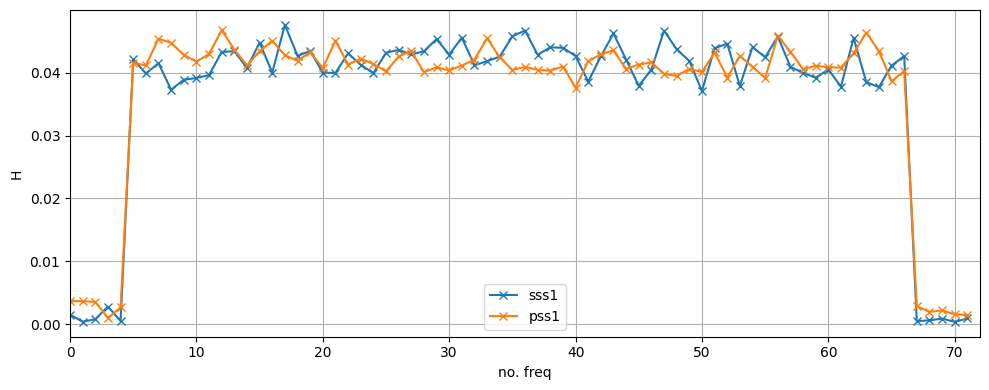

(72, 48)


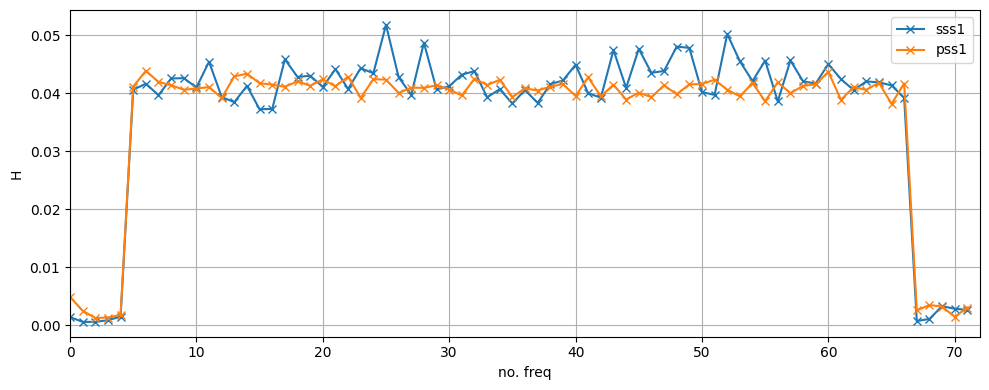

(72, 48)


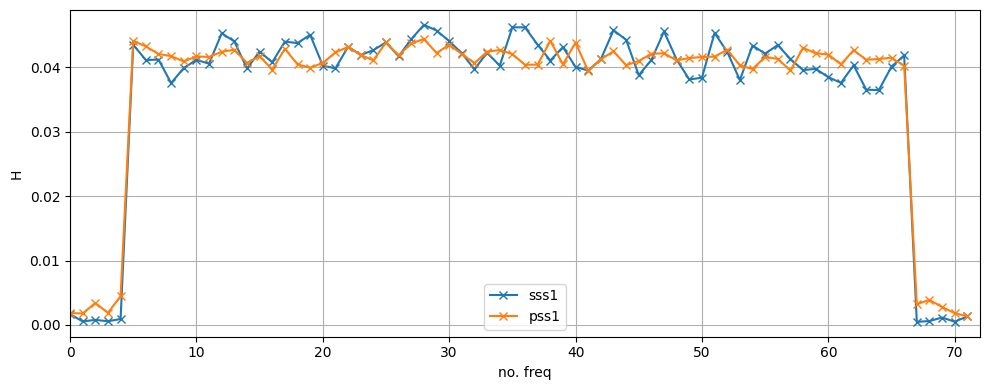

(72, 48)


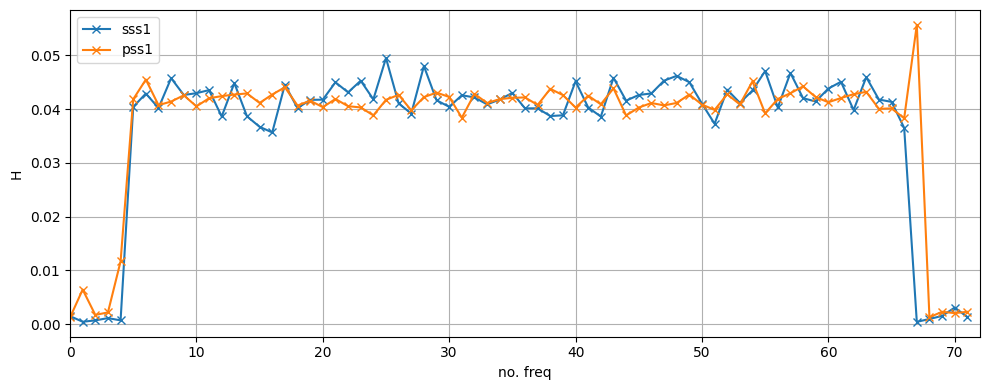

(72, 48)


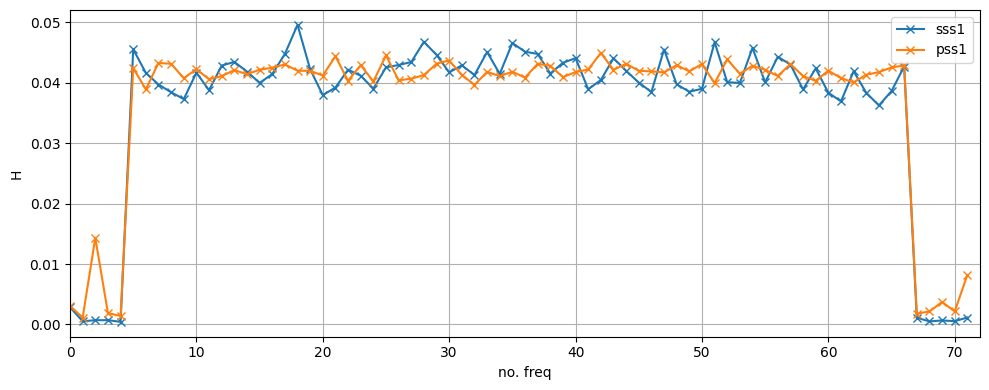

(72, 48)


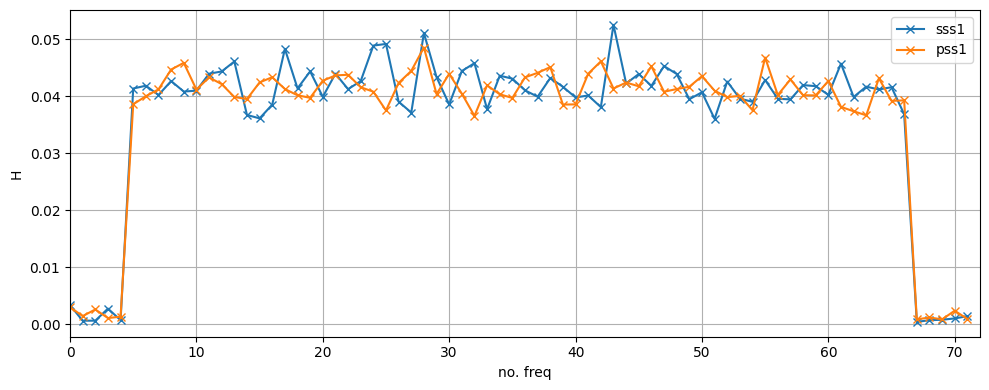

(72, 48)


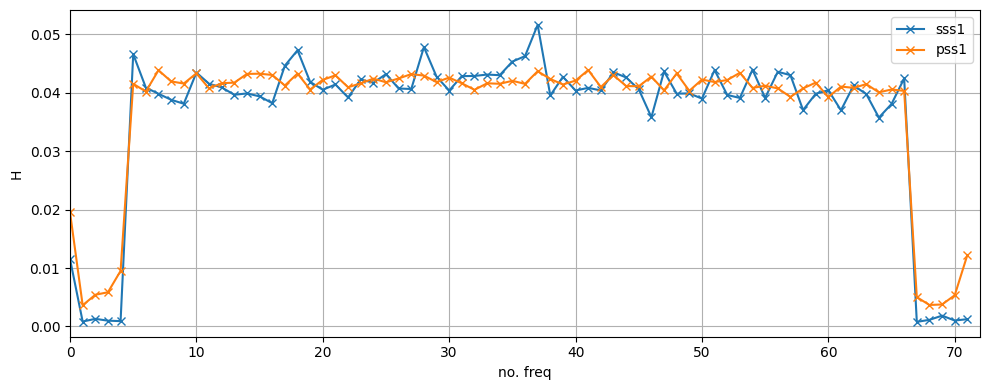

(72, 48)


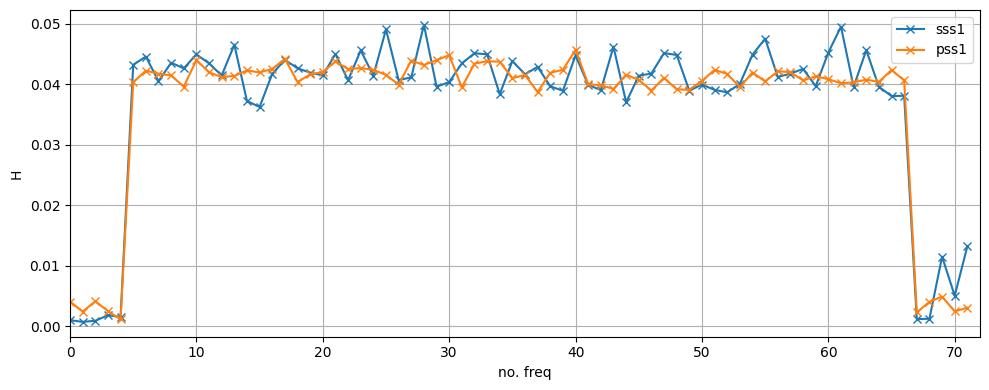

(72, 48)


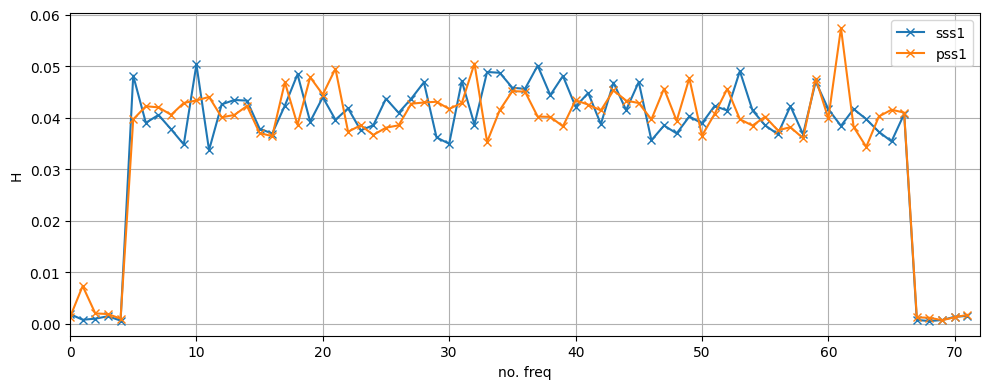

(72, 48)


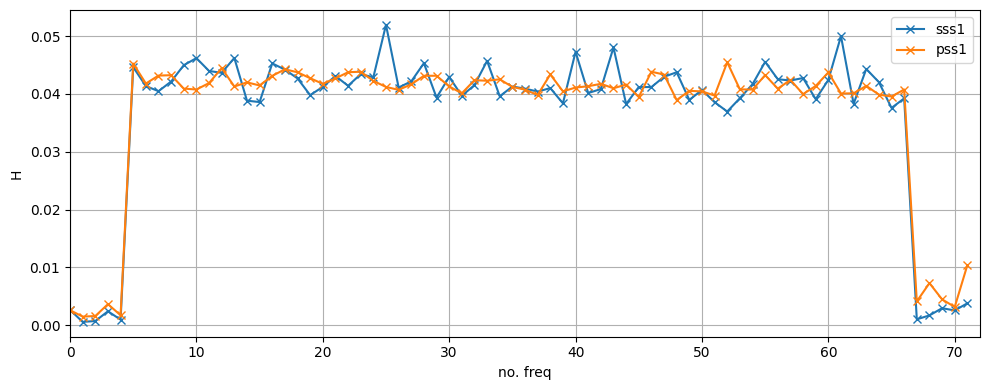

(72, 48)


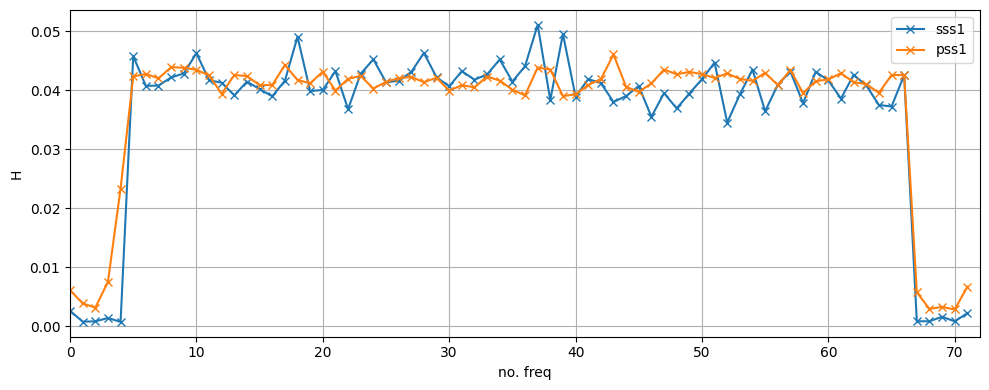

(72, 48)


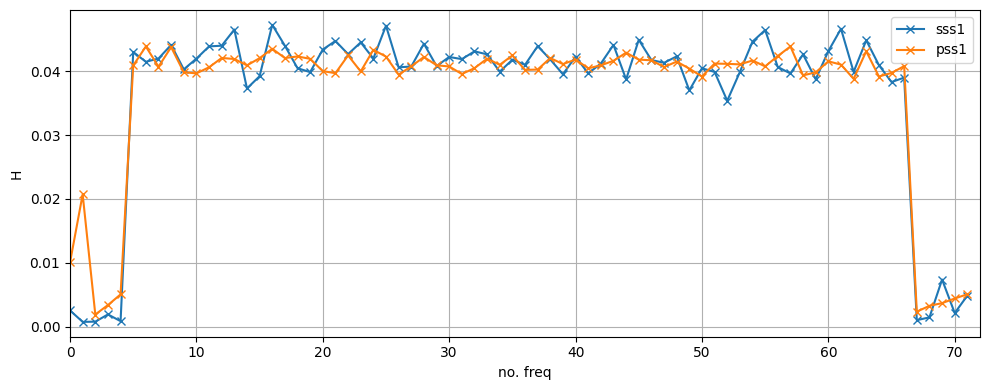

In [68]:
for x_graph in range(new_channel.shape[1]//(2*mean_vals)):
    #full_path_received = os.path.join(paths[key_world], all_files_received[x_graph])
    #mat_file_received = np.load(full_path_received)
    #channel_estim = new_channel[:, (x_graph)*2:(x_graph+1)*2]
    
    #h = pss_sss_raw*mat_file_received_four
    
    channel_estim = h_abs[:, (x_graph)*2:(x_graph+1)*2]
    
    
    ids_h = np.arange(channel_estim.shape[0])
    
    plt.figure(figsize=(10,4))
    labels = ['sss1', 'pss1', 'sss2', 'pss2']
    y_tresh = [-60,10]
    
    print(h_abs.shape)
    for x in range(0,2):
        plt.plot(ids_h, channel_estim[:,x], 'x-', label = labels[x])
    
    plt.legend()
    plt.xlabel('no. freq')
    plt.ylabel('H')
    plt.xlim([0,72])
    plt.grid()
    #plt.ylim([-70,-10])

    plt.tight_layout()
    plt.savefig(f'graph_ids={x_graph}_{key_world}.png')
    plt.show()


In [57]:
x_graph

24

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rxGridSSBurst is a numpy array with complex numbers
# Example initialization of rxGridSSBurst
rxGridSSBurst = pss_sss_raw

# Compute the cross-correlation
r = np.correlate(pss_sss_raw[:, 0], mat_file_received_four[:, 3], mode='full')
lags = np.arange(-len(rxGridSSBurst[:, 0]) + 1, len(rxGridSSBurst[:, 0]))

# Plot the result
plt.figure(1)
plt.stem(lags, np.abs(r), use_line_collection=True)
plt.xlabel('Lags')
plt.ylabel('Magnitude of Cross-Correlation')
plt.xlim([-71,71])
plt.show()



NameError: name 'mat_file_received_four' is not defined

In [16]:
h_abs

array([[3.03780935e-03, 5.69572335e-04, 2.37586570e-02, 2.94629277e-03],
       [2.42743303e-03, 7.28648050e-04, 3.06933094e-02, 3.91842889e-02],
       [2.19711127e-03, 6.09267472e-04, 3.65376548e-03, 3.71803120e-03],
       [3.33797369e-03, 5.28520229e-04, 2.15118090e-03, 5.00576636e-03],
       [4.14019596e-03, 6.33940628e-04, 2.63473202e-03, 1.75887441e-03],
       [9.13697716e-02, 6.91417716e-02, 5.65841725e-02, 5.73290212e-02],
       [8.52798903e-02, 7.30770688e-02, 6.50320833e-02, 5.58811526e-02],
       [1.41266701e-01, 1.24826515e-01, 8.63628424e-02, 5.60399090e-02],
       [3.63794640e-01, 1.11068401e+00, 5.50799356e-02, 5.58190929e-02],
       [3.11977972e-01, 2.09434954e-01, 5.76870513e-02, 6.71091939e-02],
       [9.72138657e-02, 1.38205101e-01, 7.36442703e-02, 4.58635138e-02],
       [8.86264875e-01, 1.23497844e-01, 5.96960423e-02, 6.39273535e-02],
       [1.29703301e-01, 3.54438966e-01, 8.19052795e-02, 5.57106225e-02],
       [2.02699850e-01, 9.30025127e-02, 4.85385142e